In [1]:
using Pkg
# pkg"add Oceananigans, JLD2, Plots"

In [2]:
using Oceananigans
using Oceananigans.Units
using Oceananigans.Models.HydrostaticFreeSurfaceModels: ImplicitFreeSurface
using Oceananigans.OutputReaders: FieldTimeSeries
using Plots, Printf

In [3]:
grid = RectilinearGrid(size = (128, 1),
                       x = (-1000kilometers, 1000kilometers), z = (-400meters, 0),
                       topology = (Bounded, Flat, Bounded))

RectilinearGrid{Float64, Bounded, Flat, Bounded}
             architecture: CPU()
                   domain: x ∈ [-1.0e6, 1.0e6], y ∈ [1.0, 1.0], z ∈ [-400.0, 0.0]
                 topology: (Bounded, Flat, Bounded)
        size (Nx, Ny, Nz): (128, 1, 1)
        halo (Hx, Hy, Hz): (1, 0, 1)
             spacing in x: Regular, with spacing 15625.0
             spacing in y: Flattened
             spacing in z: Regular, with spacing 400.0

In [4]:
coriolis = FPlane(f=1e-4)

FPlane{Float64}: f = 1.00e-04

In [5]:
model = HydrostaticFreeSurfaceModel(grid = grid,
                                    coriolis = coriolis,
                                    free_surface = ImplicitFreeSurface())

HydrostaticFreeSurfaceModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RectilinearGrid{Float64, Bounded, Flat, Bounded}(Nx=128, Ny=1, Nz=1)
├── tracers: (:T, :S)
├── closure: Nothing
├── buoyancy: Buoyancy{SeawaterBuoyancy{Float64, LinearEquationOfState{Float64}, Nothing, Nothing}, Oceananigans.Grids.ZDirection}
└── coriolis: FPlane{Float64}

In [6]:
gaussian(x, L) = exp(-x^2 / 2L^2)

U = 0.1 # geostrophic velocity
L = grid.Lx / 40 # Gaussian width
x₀ = grid.Lx / 4 # Gaussian center

vᵍ(x, y, z) = - U * (x - x₀) / L * gaussian(x - x₀, L)

g = model.free_surface.gravitational_acceleration

η₀ = coriolis.f * U * L / g # geostrohpic free surface amplitude

ηᵍ(x) = η₀ * gaussian(x - x₀, L)

ηᵍ (generic function with 1 method)

In [7]:
ηⁱ(x, y) = 2 * ηᵍ(x)

ηⁱ (generic function with 1 method)

In [8]:
set!(model, v=vᵍ, η=ηⁱ)

In [9]:
gravity_wave_speed = sqrt(g * grid.Lz) # hydrostatic (shallow water) gravity wave speed

wave_propagation_time_scale = model.grid.Δxᶜᵃᵃ / gravity_wave_speed

simulation = Simulation(model, Δt = 0.1wave_propagation_time_scale, stop_iteration = 1000)

Simulation{typename(HydrostaticFreeSurfaceModel){typename(CPU), Float64}}
├── Model clock: time = 0 seconds, iteration = 0
├── Next time step: 24.948 seconds
├── Elapsed wall time: 0 seconds
├── Stop time: Inf years
├── Stop iteration : 1000.0
├── Wall time limit: Inf
├── Callbacks: typename(OrderedCollections.OrderedDict) with 4 entries:
│   ├── stop_time_exceeded => typename(Callback)
│   ├── stop_iteration_exceeded => typename(Callback)
│   ├── wall_time_limit_exceeded => typename(Callback)
│   └── nan_checker => typename(Callback)
├── Output writers: typename(OrderedCollections.OrderedDict) with no entries
└── Diagnostics: typename(OrderedCollections.OrderedDict) with no entries

In [11]:
output_fields = merge(model.velocities, (η=model.free_surface.η,))
# fields = Dict("u" => model.velocities.u, "w" => model.velocities.w)

# simulation.output_writers[:fields] = NetCDFOutputWriter(model, fields,
#                                                       schedule = IterationInterval(10),
#                                                       filepath="field.nc")
simulation.output_writers[:fields] = JLD2OutputWriter(model, output_fields,
                                                      schedule = IterationInterval(10),
                                                      prefix = "geostrophic_adjustment",
                                                      field_slicer = nothing,
                                                      force = true)

run!(simulation)

┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations C:\Users\Gebruiker\.julia\packages\Oceananigans\ECYGS\src\Simulations\run.jl:168
┌ Info:     ... simulation initialization complete (5.838 seconds)
└ @ Oceananigans.Simulations C:\Users\Gebruiker\.julia\packages\Oceananigans\ECYGS\src\Simulations\run.jl:189
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations C:\Users\Gebruiker\.julia\packages\Oceananigans\ECYGS\src\Simulations\run.jl:113
┌ Info:     ... initial time step complete (54.486 seconds).
└ @ Oceananigans.Simulations C:\Users\Gebruiker\.julia\packages\Oceananigans\ECYGS\src\Simulations\run.jl:120
┌ Info: Simulation is stopping. Model iteration 1000 has hit or exceeded simulation stop iteration 1000.0.
└ @ Oceananigans.Simulations C:\Users\Gebruiker\.julia\packages\Oceananigans\ECYGS\src\Simulations\simulation.jl:152


In [12]:
u_timeseries = FieldTimeSeries("geostrophic_adjustment.jld2", "u")
v_timeseries = FieldTimeSeries("geostrophic_adjustment.jld2", "v")
η_timeseries = FieldTimeSeries("geostrophic_adjustment.jld2", "η")

xη = xw = xv = xnodes(v_timeseries)
xu = xnodes(u_timeseries)

t = u_timeseries.times

101-element Vector{Float64}:
     0.0
   249.47652873520212
   498.95305747040425
   748.4295862056058
   997.9061149408074
  1247.382643676009
  1496.8591724112105
  1746.335701146412
  1995.8122298816136
  2245.2887586168167
  2494.7652873520206
  2744.2418160872244
  2993.718344822428
     ⋮
 22203.411057433037
 22452.88758616825
 22702.364114903463
 22951.840643638676
 23201.31717237389
 23450.7937011091
 23700.270229844315
 23949.746758579528
 24199.22328731474
 24448.699816049953
 24698.176344785166
 24947.65287352038

In [13]:
anim = @animate for i = 1:length(t)

    u = interior(u_timeseries[i])[:, 1, 1]
    v = interior(v_timeseries[i])[:, 1, 1]
    η = interior(η_timeseries[i])[:, 1, 1]

    titlestr = @sprintf("Geostrophic adjustment at t = %.1f hours", t[i] / hours)

    u_plot = plot(xu / kilometers, u, linewidth = 2,
                  label = "", xlabel = "x (km)", ylabel = "u (m s⁻¹)", ylims = (-2e-3, 2e-3))

    v_plot = plot(xv / kilometers, v, linewidth = 2, title = titlestr,
                  label = "", xlabel = "x (km)", ylabel = "v (m s⁻¹)", ylims = (-U, U))

    η_plot = plot(xη / kilometers, η, linewidth = 2,
                  label = "", xlabel = "x (km)", ylabel = "η (m)", ylims = (-η₀/10, 2η₀))

    plot(v_plot, u_plot, η_plot, layout = (3, 1), size = (800, 600))
end

Animation("C:\\Users\\GEBRUI~1\\AppData\\Local\\Temp\\jl_6svXWz", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000092.png", "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png", "000100.png", "000101.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\Gebruiker\Documents\Programming\anim2_fps15.gif
└ @ Plots C:\Users\Gebruiker\.julia\packages\Plots\UeTBV\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Gebruiker\\Documents\\Programming\\anim2_fps15.gif")
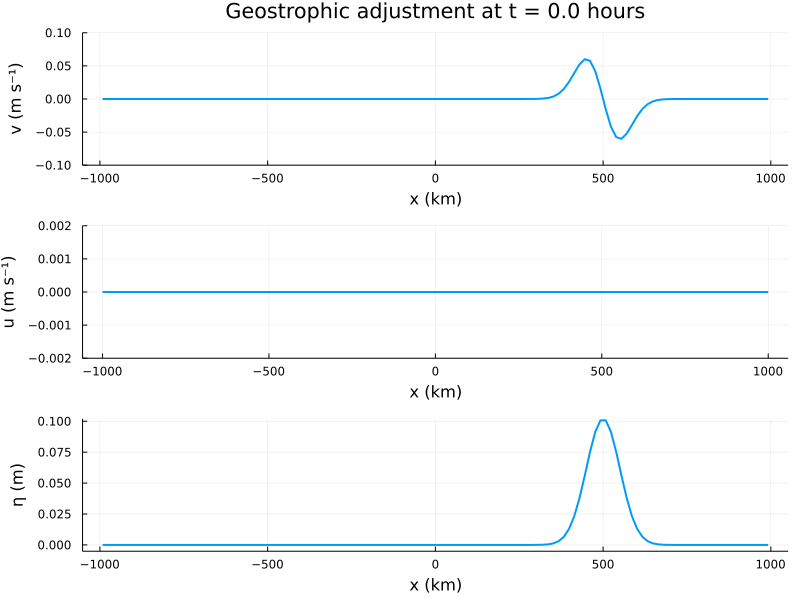

In [14]:
gif(anim, "anim2_fps15.gif", fps = 15)

## Sign(x)

In [66]:
grid = RectilinearGrid(size = (2000, 1),
                       x = (-1e5kilometers, 1e5kilometers), y = (-10kilometers, 10kilometers) z = (-4000meters, 0),
                       topology = (Bounded, Flat, Bounded))

RectilinearGrid{Float64, Bounded, Flat, Bounded}
             architecture: CPU()
                   domain: x ∈ [-1.0e8, 1.0e8], y ∈ [1.0, 1.0], z ∈ [-4000.0, 0.0]
                 topology: (Bounded, Flat, Bounded)
        size (Nx, Ny, Nz): (2000, 1, 1)
        halo (Hx, Hy, Hz): (1, 0, 1)
             spacing in x: Regular, with spacing 100000.0
             spacing in y: Flattened
             spacing in z: Regular, with spacing 4000.0

In [67]:
coriolis = FPlane(f=1e-4)

FPlane{Float64}: f = 1.00e-04

In [68]:
model = HydrostaticFreeSurfaceModel(grid = grid,
                                    coriolis = coriolis,
                                    free_surface = ImplicitFreeSurface())

HydrostaticFreeSurfaceModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RectilinearGrid{Float64, Bounded, Flat, Bounded}(Nx=2000, Ny=1, Nz=1)
├── tracers: (:T, :S)
├── closure: Nothing
├── buoyancy: Buoyancy{SeawaterBuoyancy{Float64, LinearEquationOfState{Float64}, Nothing, Nothing}, Oceananigans.Grids.ZDirection}
└── coriolis: FPlane{Float64}

In [69]:
U = 0.1 # geostrophic velocity
L = grid.Lx / 40 # Gaussian width
x₀ = grid.Lx / 4 # Gaussian center

# vᵍ(x, y, z) = - U * (x - x₀) / L * gaussian(x - x₀, L)
v₀(x, y, z) = 0*x

g = model.free_surface.gravitational_acceleration

η₀ = coriolis.f * U * L / g # geostrohpic free surface amplitude

gravity_wave_speed = sqrt(g * grid.Lz) # hydrostatic (shallow water) gravity wave speed

wave_propagation_time_scale = model.grid.Δxᶜᵃᵃ / gravity_wave_speed

simulation_sign = Simulation(model, Δt = 0.1wave_propagation_time_scale, stop_iteration = 10000)

Simulation{typename(HydrostaticFreeSurfaceModel){typename(CPU), Float64}}
├── Model clock: time = 0 seconds, iteration = 0
├── Next time step: 50.490 seconds
├── Elapsed wall time: 0 seconds
├── Stop time: Inf years
├── Stop iteration : 10000.0
├── Wall time limit: Inf
├── Callbacks: typename(OrderedCollections.OrderedDict) with 4 entries:
│   ├── stop_time_exceeded => typename(Callback)
│   ├── stop_iteration_exceeded => typename(Callback)
│   ├── wall_time_limit_exceeded => typename(Callback)
│   └── nan_checker => typename(Callback)
├── Output writers: typename(OrderedCollections.OrderedDict) with no entries
└── Diagnostics: typename(OrderedCollections.OrderedDict) with no entries

In [70]:
ηʲ(x, y) = sign(x)

ηʲ (generic function with 1 method)

In [71]:
set!(model, v=v₀, η=ηʲ)

In [72]:
output_fields = merge(model.velocities, (η=model.free_surface.η,))

simulation_sign.output_writers[:fields] = JLD2OutputWriter(model, output_fields,
                                                      schedule = IterationInterval(10),
                                                      prefix = "geostrophic_adjustment_sign",
                                                      field_slicer = nothing,
                                                      force = true)

run!(simulation_sign)

┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations C:\Users\Gebruiker\.julia\packages\Oceananigans\ECYGS\src\Simulations\run.jl:168
┌ Info:     ... simulation initialization complete (15.205 ms)
└ @ Oceananigans.Simulations C:\Users\Gebruiker\.julia\packages\Oceananigans\ECYGS\src\Simulations\run.jl:189
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations C:\Users\Gebruiker\.julia\packages\Oceananigans\ECYGS\src\Simulations\run.jl:113
┌ Info:     ... initial time step complete (28.743 ms).
└ @ Oceananigans.Simulations C:\Users\Gebruiker\.julia\packages\Oceananigans\ECYGS\src\Simulations\run.jl:120
┌ Info: Simulation is stopping. Model iteration 10000 has hit or exceeded simulation stop iteration 10000.0.
└ @ Oceananigans.Simulations C:\Users\Gebruiker\.julia\packages\Oceananigans\ECYGS\src\Simulations\simulation.jl:152


In [73]:
u_timeseries = FieldTimeSeries("geostrophic_adjustment_sign.jld2", "u")
v_timeseries = FieldTimeSeries("geostrophic_adjustment_sign.jld2", "v")
η_timeseries = FieldTimeSeries("geostrophic_adjustment_sign.jld2", "η")

xη = xw = xv = xnodes(v_timeseries)
xu = xnodes(u_timeseries)

t = u_timeseries.times

1001-element Vector{Float64}:
      0.0
    504.90499427563805
   1009.8099885512761
   1514.7149828269153
   2019.6199771025545
   2524.5249713781936
   3029.429965653833
   3534.334959929472
   4039.239954205111
   4544.14494848075
   5049.049942756389
   5553.954937032028
   6058.8599313076675
      ⋮
 499351.03933851403
 499855.94433278946
 500360.8493270649
 500865.7543213403
 501370.6593156157
 501875.56430989114
 502380.46930416656
 502885.374298442
 503390.2792927174
 503895.1842869928
 504400.08928126824
 504904.99427554366

In [74]:
anim_sign = @animate for i = 1:length(t)

    u = interior(u_timeseries[i])[:, 1, 1]
    v = interior(v_timeseries[i])[:, 1, 1]
    η = interior(η_timeseries[i])[:, 1, 1]

    titlestr = @sprintf("Geostrophic adjustment at t = %.1f hours", t[i] / hours)

    u_plot = plot(xu / kilometers, u, linewidth = 2,
                  label = "", xlabel = "x (km)", ylabel = "u (m s⁻¹)", ylims = (-U, U))

    v_plot = plot(xv / kilometers, v, linewidth = 2, title = titlestr,
                  label = "", xlabel = "x (km)", ylabel = "v (m s⁻¹)", ylims = (-U, U))

    η_plot = plot(xη / kilometers, η, linewidth = 2,
                  label = "", xlabel = "x (km)", ylabel = "η (m)", ylims = (-1.1, 1.1))

    plot(v_plot, u_plot, η_plot, layout = (3, 1), size = (800, 600))
end

Animation("C:\\Users\\GEBRUI~1\\AppData\\Local\\Temp\\jl_KRGPt9", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000992.png", "000993.png", "000994.png", "000995.png", "000996.png", "000997.png", "000998.png", "000999.png", "001000.png", "001001.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\Gebruiker\Documents\Programming\anim_sign_fps15.gif
└ @ Plots C:\Users\Gebruiker\.julia\packages\Plots\UeTBV\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Gebruiker\\Documents\\Programming\\anim_sign_fps15.gif")
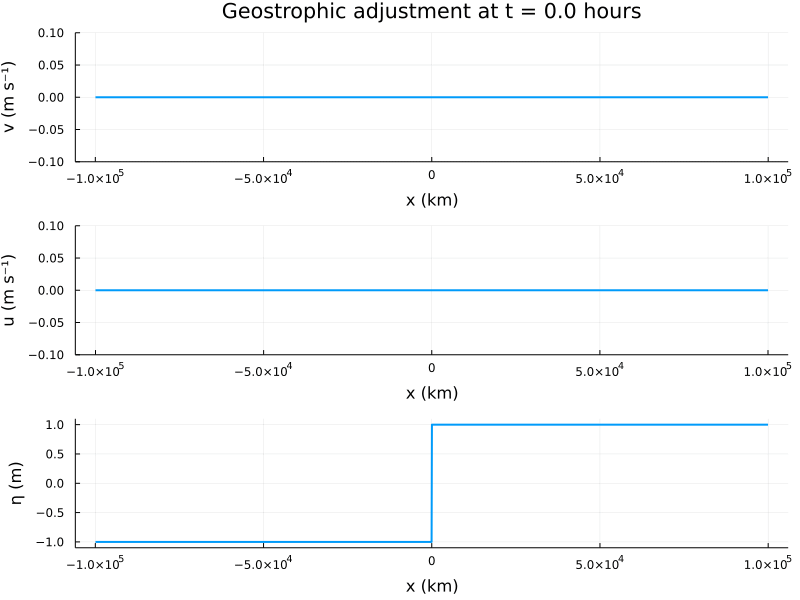

In [75]:
gif(anim_sign, "anim_sign_fps15.gif", fps = 15)